In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
Meshcat url:  http://127.0.0.1:7003/static/


In [4]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 30
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in range(N_samples):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

Loaded 30 scenes.


In [5]:
# Initialize a grammar with bad parameter guesses.
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=True
)

def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")
    
def get_posterior_tree_samples_from_observation(grammar, observed_nodes, num_mcmc_steps=15, subsample_rate=3, verbose=0):
    draw_scene_tree_contents_meshcat(
        SceneTree.make_from_observed_nodes(observed_nodes), zmq_url=vis.window.zmq_url, prefix="observed"
    )
    
    # Use a MIP to get MAP structure.
    mip_results = infer_mle_tree_with_mip(
        grammar, observed_nodes, verbose=verbose, max_scene_extent_in_any_dir=10.
    )
    mip_optimized_tree = get_optimized_tree_from_mip_results(mip_results)
    # Use NLP to refine that to a MAP estimate.
    refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=verbose)
    refined_tree = refinement_results.refined_tree

    # And sample trees around that MAP estimate with the
    # same structure.
    sampled_trees = do_fixed_structure_mcmc(
        grammar, refined_tree, num_samples=num_mcmc_steps, verbose=verbose,
        perturb_in_config_space=True, translation_variance=1.0, rotation_variance=1.0,
        do_hit_and_run_postprocess=False, vis_callback=do_vis
    )
    
    # Finally, subsample the sampled trees as requested and return
    # the sampled set.
    return sampled_trees[::subsample_rate]

def collect_posterior_sample_sets(observed_node_sets):
    posterior_sample_sets = []
    for observed_nodes in tqdm(observed_node_sets, desc='Collecting posterior samples'):
        posterior_samples = get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0, subsample_rate=2, num_mcmc_steps=10)
        posterior_sample_sets.append(posterior_samples)
    return posterior_sample_sets
posterior_sample_sets = collect_posterior_sample_sets(observed_node_sets)

[2021-09-03 01:29:27.244] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Text(0.5, 1.0, 'Score history')

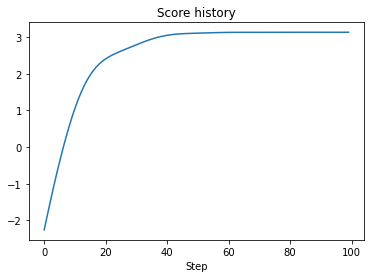

In [6]:
# And now do gradient descent on the grammar parameters
# by summing the score of all of those trees.

# Reattach tree params to prepare for grad descent.
tree_set = sum(posterior_sample_sets, [])

def calc_mean_score(tree_set):
    total_score = 0.
    total_k = 0.
    for tree in tree_set:
        total_score = total_score + tree.score()
        total_k += 1
    return total_score / total_k

log_by_node_type = {node_type.__name__: [] for node_type in grammar.all_types}
def log_params(grammar):
    for node_type_name, params in grammar.params_by_node_type.items():
        if params is not None:
            log_by_node_type[node_type_name].append(params().detach())
        
optimizer = torch.optim.Adam(grammar.parameters(), lr=0.1)
pbar = tqdm(range(100), desc="Optimizing parameters")
score_history = []
for step_k in pbar:
    # Update parameter settings
    log_params(grammar)
    for tree in tree_set:
        grammar.update_tree_grammar_parameters(tree)
    score = calc_mean_score(tree_set)
    score_history.append(score)
    # Gradient step
    optimizer.zero_grad()
    (-score).backward(retain_graph=True)
    optimizer.step()
    pbar.set_description("Mean score %2.2f" % score)
plt.plot(score_history)
plt.xlabel("Step")
plt.title("Score history")

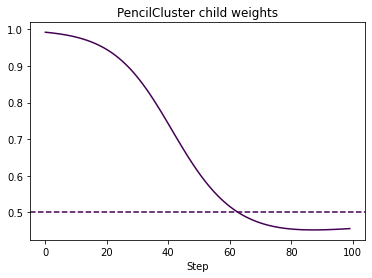

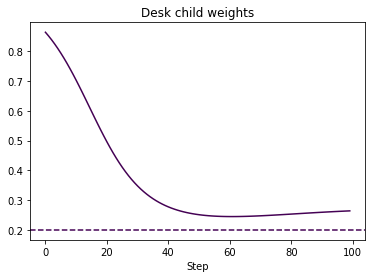

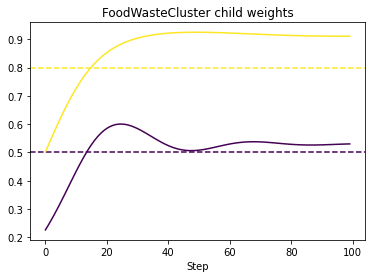

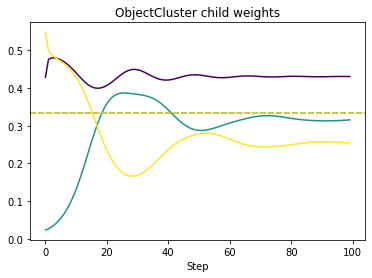

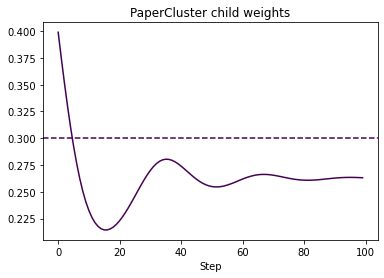

In [7]:
# Plot param logs
cm = plt.get_cmap('viridis')
for node_type_name, log in log_by_node_type.items():
    if len(log) > 0:
        plt.figure()
        data = torch.stack(log, axis=0).numpy()
        n_vars = data.shape[1]
        ground_truth_values = ground_truth_grammar.params_by_node_type[node_type_name]()
        for var_k in range(n_vars):
            c = cm(float(var_k) / max(1, (n_vars-1)))
            plt.plot(data[:, var_k], color=c, label="Fit")
            plt.axhline(ground_truth_values[var_k], color=c, linestyle="--", label="GT")
        plt.title(node_type_name + " child weights")
        plt.xlabel("Step")